In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)  # Change from INFO to DEBUG

### Testing WESAD Data Preparation

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

from data_preparation.wesad_preparer import WESADPreparer  

preparer = WESADPreparer(
    data_path="../raw_data/WESAD",
    output_dir="../data/processed/wesad"
)

result = preparer.process_subject(2)  # Test with subject 2
print(f"Processing result: {result}")

INFO:WESADLoader:S2 BVP samples (389056) deviate from expected (460800)
INFO:WESADLoader:S2 ACC samples (583584) deviate from expected (230400)
INFO:WESADLoader:Normalized BVP range: -865.13-962.00 → [-1, 1]


Processing result: {'status': 'success', 'subject': 2, 'files': ['../data/processed/wesad/clean_wesad_s2.parquet', '../data/processed/wesad/apple_watch_I-II_wesad_s2.parquet', '../data/processed/wesad/apple_watch_III-IV_wesad_s2.parquet', '../data/processed/wesad/apple_watch_V-VI_wesad_s2.parquet', '../data/processed/wesad/galaxy_watch_I-II_wesad_s2.parquet', '../data/processed/wesad/galaxy_watch_III-IV_wesad_s2.parquet', '../data/processed/wesad/galaxy_watch_V-VI_wesad_s2.parquet']}


### Tesing Phsionet Data preparation

In [4]:
from pathlib import Path
from data_preparation.physionet_preparer import PhysioNetPreparer

preparer = PhysioNetPreparer(
    data_path="../raw_data/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data",
    output_dir="../data/processed/physionet"
)

# Process a subject's final exam
result = preparer.process_subject(1, exam_type='Midterm 1')
print(f"Processing result: {result}")



DEBUG:PhysioNetPreparer:Clean data index start: 2020-01-02 08:00:00+00:00, length: 338735


Processing result: {'status': 'success', 'files': ['../data/processed/physionet/clean_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/apple_watch_I-II_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/apple_watch_III-IV_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/apple_watch_V-VI_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/galaxy_watch_I-II_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/galaxy_watch_III-IV_physionet_s1_Midterm 1.parquet', '../data/processed/physionet/galaxy_watch_V-VI_physionet_s1_Midterm 1.parquet'], 'subject': 1, 'exam': 'Midterm 1'}


### Test Alignment with Sample Data

In [5]:
from data_preparation.sensor_alignment import SensorAligner
import pandas as pd

# Test PPG alignment
test_data = pd.DataFrame({'bvp': [1.0, 1.0, 1.0]})
aligner = SensorAligner()

# PhysioNet data should be scaled down
physionet_aligned = aligner.align_ppg(test_data, 'physionet')
print(f"PhysioNet PPG: {physionet_aligned.bvp.values}")

# Test ACC remapping
acc_data = pd.DataFrame({
    'acc_x': [1, 0, 0],  # North
    'acc_y': [0, 1, 0],  # East 
    'acc_z': [0, 0, 1]   # Down
})

physionet_acc = aligner.align_acc(acc_data, 'physionet')
print("\nPhysioNet ACC Remapped:")
print(physionet_acc[['acc_x', 'acc_y', 'acc_z']])

PhysioNet PPG: [0.9545 0.9545 0.9545]

PhysioNet ACC Remapped:
   acc_x  acc_y  acc_z
0      0      1      0
1      1      0      0
2      0      0     -1


### Verify Noise Effects

In [6]:
clean = pd.read_parquet("../data/processed/physionet/clean_physionet_s1_Midterm 1.parquet")
apple = pd.read_parquet("../data/processed/physionet/apple_watch_III-IV_physionet_s1_Midterm 1.parquet")
galaxy = pd.read_parquet("../data/processed/physionet/galaxy_watch_I-II_physionet_s1_Midterm 1.parquet")

# Align using index intersection
common_index = clean.index.intersection(apple.index)
clean_aligned = clean.loc[common_index]
apple_aligned = apple.loc[common_index]

print(f"Clean-Apple alignment: {clean.index.equals(apple.index)}")  # Should be True
print(f"Clean-Galaxy alignment: {clean.index.equals(galaxy.index)}")  # Should be True

# After loading parquet files
print("Index types:")
print(f"Clean index type: {type(clean.index)}")
print(f"Apple index type: {type(apple.index)}")
print(f"First timestamp match: {clean.index[0] == apple.index[0]}")

print("Aligned Comparison:")
print(pd.DataFrame({
    'Clean': clean_aligned.bvp[:100:10],
    'Noisy': apple_aligned.bvp[:100:10]
}))

Clean-Apple alignment: True
Clean-Galaxy alignment: True
Index types:
Clean index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Apple index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First timestamp match: True
Aligned Comparison:
                                   Clean       Noisy
2020-01-02 08:00:00+00:00          -0.00    8.047747
2020-01-02 08:00:00.333000+00:00    1.01    6.922839
2020-01-02 08:00:00.667000+00:00   14.30   18.661442
2020-01-02 08:00:01+00:00          98.12   66.238329
2020-01-02 08:00:01.333000+00:00  103.79   78.511016
2020-01-02 08:00:01.667000+00:00 -205.64 -170.493900
2020-01-02 08:00:02+00:00           7.98    3.998653
2020-01-02 08:00:02.333000+00:00   18.08   25.837766
2020-01-02 08:00:02.667000+00:00    9.25   10.985732
2020-01-02 08:00:03+00:00           5.74   17.252027


### Test Skin Tone Effects

DEBUG:matplotlib:matplotlib data path: /Users/uvaishnav/anaconda3/envs/stress_monitor/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/uvaishnav/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/uvaishnav/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/uvaishnav/.matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/uvaishnav/anaconda3/envs/stress_monitor/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='n

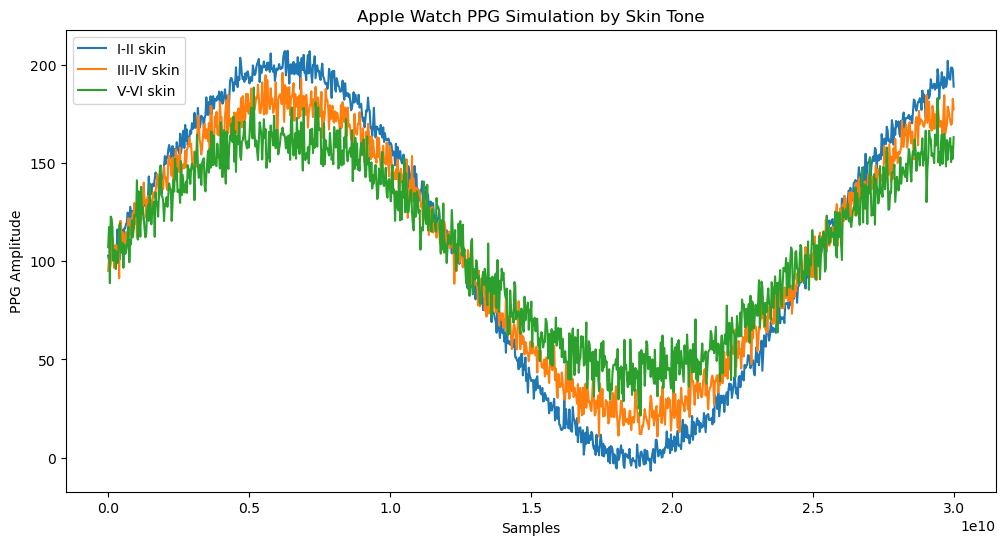

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data_preparation.noise_simulator import NoiseSimulator

# Create full sensor dataframe with dummy ACC values
test_df = pd.DataFrame(
    data={
        'bvp': np.sin(np.linspace(0, 2*np.pi*1.2, 1000)) * 100 + 100,
        'acc_x': 0.5,
        'acc_y': -0.3,
        'acc_z': 1.0
    },
    index=pd.timedelta_range(start=0, periods=1000, freq='30ms')  # Time-based index
)

sim = NoiseSimulator()
skin_types = ['I-II', 'III-IV', 'V-VI']

plt.figure(figsize=(12, 6))
for skin in skin_types:
    noisy = sim.add_device_noise(
        test_df.copy(),
        device='apple_watch',
        skin_tone=skin
    )
    plt.plot(noisy['bvp'], label=f'{skin} skin')

plt.title("Apple Watch PPG Simulation by Skin Tone")
plt.ylabel("PPG Amplitude")
plt.xlabel("Samples")
plt.legend()
plt.show()

#### Quantify Skin Tone Impact

In [8]:
# In the test notebook cell
import numpy as np
import pandas as pd
from data_preparation.noise_simulator import NoiseSimulator

# 1. Create Clean Calibration Signal with ZERO motion
base_freq = 1.2  # Hz
ac_amplitude = 100  # μV
t = np.linspace(0, 30, 1000)

clean_ppg = 1000 + ac_amplitude * np.sin(2 * np.pi * base_freq * t)
test_df = pd.DataFrame({
    'bvp': clean_ppg,
    'acc_x': 0.0 * np.ones_like(t),  # Zero motion
    'acc_y': 0.0 * np.ones_like(t),  # Zero motion
    'acc_z': 0.0 * np.ones_like(t)   # Zero motion
})

# 2. Configure Noise Simulation (isolate PPG noise)
sim = NoiseSimulator()
sim.base_device_noise = 0.0  # Disable base noise

# Use CORRECT parameter names matching the class
sim.skin_effects = {
    'I-II': {'gain': 1.0, 'noise': 4.0, 'motion_multiplier': 0.0},
    'III-IV': {'gain': 0.8, 'noise': 6.0, 'motion_multiplier': 0.0},
    'V-VI': {'gain': 0.6, 'noise': 8.0, 'motion_multiplier': 0.0}
}

# 3. Analysis with Zero Motion Interference
for skin in ['I-II', 'III-IV', 'V-VI']:
    noisy_df = sim.add_device_noise(test_df.copy(), 'apple_watch', skin)
    params = sim.skin_effects[skin]  # Now using class's parameter names
    
    # Calculate pure PPG noise (use 'gain' instead of 'ppg_gain')
    clean_ac = (test_df['bvp'] - test_df['bvp'].mean()) * params['gain']
    noisy_ac = noisy_df['bvp'] - noisy_df['bvp'].mean()
    noise = noisy_ac - clean_ac
    
    # Metrics (use 'noise' instead of 'ppg_noise')
    signal_rms = np.sqrt(np.mean(clean_ac**2))
    noise_rms = np.sqrt(np.mean(noise**2))
    
    print(f"{skin} Skin:")
    print(f"  Measured Noise: {noise_rms:.1f} μV (Expected: {params['noise']:.1f} μV)")
    print(f"  SNR: {20*np.log10(signal_rms/noise_rms):.1f} dB\n")

I-II Skin:
  Measured Noise: 3.9 μV (Expected: 4.0 μV)
  SNR: 25.2 dB

III-IV Skin:
  Measured Noise: 6.0 μV (Expected: 6.0 μV)
  SNR: 19.4 dB

V-VI Skin:
  Measured Noise: 7.8 μV (Expected: 8.0 μV)
  SNR: 14.7 dB



### generated data

In [9]:
phy_apple_data = pd.read_parquet("../data/processed/physionet/apple_watch_I-II_physionet_s1_Midterm 1.parquet")
phy_apple_data.tail()

,hr,eda,temp,bvp,acc_y,acc_x,acc_z,label,subject_id,exam_type,dataset,device,skin_tone,noise_level
2020-01-02 11:08:11+00:00,139.7,0.025628,25.55,-14.777993,56.043815,-20.033992,-18.414814,1,1,Midterm 1,physionet,apple_watch,I-II,0.07712
2020-01-02 11:08:11.033000+00:00,139.7,0.025628,25.55,-13.915908,55.957397,-20.032310,-18.090139,1,1,Midterm 1,physionet,apple_watch,I-II,0.07712
2020-01-02 11:08:11.067000+00:00,139.7,0.025628,25.55,-19.924424,55.965988,-20.106541,-18.102888,1,1,Midterm 1,physionet,apple_watch,I-II,0.07712
2020-01-02 11:08:11.100000+00:00,139.7,0.025628,25.55,-21.438166,56.091606,-20.118055,-17.919643,1,1,Midterm 1,physionet,apple_watch,I-II,0.07712
2020-01-02 11:08:11.133000+00:00,139.7,0.025628,25.55,-21.387506,56.033158,-19.880020,-17.896907,1,1,Midterm 1,physionet,apple_watch,I-II,0.07712


In [10]:
phy_apple_data.isnull().sum()

hr             0
eda            0
temp           0
bvp            0
acc_y          0
acc_x          0
acc_z          0
label          0
subject_id     0
exam_type      0
dataset        0
device         0
skin_tone      0
noise_level    0
dtype: int64

In [12]:
phy_sam_data = pd.read_parquet("../data/processed/physionet/galaxy_watch_III-IV_physionet_s1_Midterm 1.parquet")
phy_sam_data.head()

,hr,eda,temp,bvp,acc_y,acc_x,acc_z,label,subject_id,exam_type,dataset,device,skin_tone,noise_level
2020-01-02 08:00:00+00:00,0.0,0.0,22.51,16.657857,-3.0,-68.2,-12.0,0,1,Midterm 1,physionet,galaxy_watch,III-IV,0.096
2020-01-02 08:00:00.033000+00:00,0.0,0.0,22.51,12.100465,-3.0,-68.2,-12.0,0,1,Midterm 1,physionet,galaxy_watch,III-IV,0.096
2020-01-02 08:00:00.067000+00:00,0.0,0.0,22.51,-17.288522,-3.0,-68.2,-12.0,0,1,Midterm 1,physionet,galaxy_watch,III-IV,0.096
2020-01-02 08:00:00.100000+00:00,0.0,0.0,22.51,5.155975,-3.0,-68.2,-12.0,0,1,Midterm 1,physionet,galaxy_watch,III-IV,0.096
2020-01-02 08:00:00.133000+00:00,0.0,0.0,22.51,4.506152,-3.0,-68.2,-12.0,0,1,Midterm 1,physionet,galaxy_watch,III-IV,0.096


In [13]:
phy_sam_data.isnull().sum()

hr             0
eda            0
temp           0
bvp            0
acc_y          0
acc_x          0
acc_z          0
label          0
subject_id     0
exam_type      0
dataset        0
device         0
skin_tone      0
noise_level    0
dtype: int64

In [14]:
phy_clean_data = pd.read_parquet("../data/processed/physionet/clean_physionet_s1_Midterm 1.parquet")
phy_clean_data.head()

,hr,eda,temp,bvp,acc_x,acc_y,acc_z,label,subject_id,exam_type,dataset,device,skin_tone,noise_level
2020-01-02 08:00:00+00:00,0.0,0.0,22.51,-0.0,-3.0,-62.0,12.0,0,1,Midterm 1,physionet,clean,none,0.0
2020-01-02 08:00:00.033000+00:00,0.0,0.0,22.51,-0.0,-3.0,-62.0,12.0,0,1,Midterm 1,physionet,clean,none,0.0
2020-01-02 08:00:00.067000+00:00,0.0,0.0,22.51,-0.0,-3.0,-62.0,12.0,0,1,Midterm 1,physionet,clean,none,0.0
2020-01-02 08:00:00.100000+00:00,0.0,0.0,22.51,-0.0,-3.0,-62.0,12.0,0,1,Midterm 1,physionet,clean,none,0.0
2020-01-02 08:00:00.133000+00:00,0.0,0.0,22.51,-0.0,-3.0,-62.0,12.0,0,1,Midterm 1,physionet,clean,none,0.0


In [15]:
phy_clean_data.isnull().sum()

hr             0
eda            0
temp           0
bvp            0
acc_x          0
acc_y          0
acc_z          0
label          0
subject_id     0
exam_type      0
dataset        0
device         0
skin_tone      0
noise_level    0
dtype: int64

In [16]:
wesad_data_clean = pd.read_parquet("../data/processed/wesad/clean_wesad_s2.parquet")

In [18]:
wesad_data_clean.head()

,bvp,acc_x,acc_y,acc_z,label,subject_id,skin_tone,device,dataset,noise_level
timestamp,,,,,,,,,,
2025-02-21 00:00:00.000000,-0.110099,3.5,-3.5,3.5,0,2,none,clean,wesad,0.0
2025-02-21 00:00:00.033333,-0.082835,3.5,3.5,3.5,0,2,none,clean,wesad,0.0
2025-02-21 00:00:00.066666,-0.055595,3.5,3.5,3.5,0,2,none,clean,wesad,0.0
2025-02-21 00:00:00.099999,-0.032986,3.5,3.5,3.5,0,2,none,clean,wesad,0.0
2025-02-21 00:00:00.133332,-0.017065,3.5,3.5,3.5,0,2,none,clean,wesad,0.0


In [19]:
wesad_data_clean.isnull().sum()

bvp            0
acc_x          0
acc_y          0
acc_z          0
label          0
subject_id     0
skin_tone      0
device         0
dataset        0
noise_level    0
dtype: int64

In [20]:
wesad_data_clean['label'].value_counts()

label
0    137746
1     24267
2     13046
3      7679
Name: count, dtype: int64

In [21]:
wesad_data_apple = pd.read_parquet("../data/processed/wesad/apple_watch_V-VI_wesad_s2.parquet")

In [22]:
wesad_data_apple.head()

,bvp,acc_x,acc_y,acc_z,label,subject_id,skin_tone,device,dataset,noise_level
timestamp,,,,,,,,,,
2025-02-21 00:00:00.000000,-7.983449,3.575371,-3.164763,3.145767,0,2,V-VI,apple_watch,wesad,0.05088
2025-02-21 00:00:00.033333,1.621754,3.466107,3.370539,3.277511,0,2,V-VI,apple_watch,wesad,0.05088
2025-02-21 00:00:00.066666,11.162743,3.407061,3.413072,3.413895,0,2,V-VI,apple_watch,wesad,0.05088
2025-02-21 00:00:00.099999,4.937886,3.736974,3.818431,3.992842,0,2,V-VI,apple_watch,wesad,0.05088
2025-02-21 00:00:00.133332,-0.266927,3.182849,3.473665,3.806214,0,2,V-VI,apple_watch,wesad,0.05088


In [23]:
wesad_data_apple.isnull().sum()

bvp            0
acc_x          0
acc_y          0
acc_z          0
label          0
subject_id     0
skin_tone      0
device         0
dataset        0
noise_level    0
dtype: int64

In [24]:
wesad_data_samsung = pd.read_parquet("../data/processed/wesad/galaxy_watch_I-II_wesad_s2.parquet")

In [25]:
wesad_data_samsung.head()

,bvp,acc_x,acc_y,acc_z,label,subject_id,skin_tone,device,dataset,noise_level
timestamp,,,,,,,,,,
2025-02-21 00:00:00.000000,0.707453,3.85,-3.5,3.5,0,2,I-II,galaxy_watch,wesad,0.11568
2025-02-21 00:00:00.033333,0.618828,3.85,3.5,3.5,0,2,I-II,galaxy_watch,wesad,0.11568
2025-02-21 00:00:00.066666,1.072451,3.85,3.5,3.5,0,2,I-II,galaxy_watch,wesad,0.11568
2025-02-21 00:00:00.099999,8.198402,3.85,3.5,3.5,0,2,I-II,galaxy_watch,wesad,0.11568
2025-02-21 00:00:00.133332,0.599369,3.85,3.5,3.5,0,2,I-II,galaxy_watch,wesad,0.11568


In [26]:
wesad_data_samsung.isnull().sum()

bvp            0
acc_x          0
acc_y          0
acc_z          0
label          0
subject_id     0
skin_tone      0
device         0
dataset        0
noise_level    0
dtype: int64

## Unified Dataset Creation

In [3]:
from data_preparation.pipeline import UnifiedDataPipeline
from pathlib import Path

import logging
logging.basicConfig(level=logging.DEBUG)

In [4]:
def generate_unified_dataset():
    # Initialize pipeline with default output directory
    pipeline = UnifiedDataPipeline(
    raw_data_dir=Path('../raw_data'),
    output_dir=Path('../data/processed')
)
    
    # Process all subjects from both datasets
    pipeline.run_batch(
        subject_ids=[
            *range(1, 11),   # PhysioNet subjects (lines 133-135 in pipeline.py)
            *range(2, 18)    # WESAD subjects (lines 38-43 in pipeline.py)
        ],
        datasets=['physionet', 'wesad']
    )

In [5]:
generate_unified_dataset()

INFO:DataPipeline:Starting batch processing of 26 subjects
DEBUG:PhysioNetPreparer:Clean data index start: 2020-01-02 08:00:00+00:00, length: 338735
INFO:DataPipeline:Skipping Midterm 2 - empty tags.csv
INFO:DataPipeline:Skipping Final - empty tags.csv
DEBUG:PhysioNetPreparer:Clean data index start: 2020-01-03 08:00:00+00:00, length: 363162
DEBUG:PhysioNetPreparer:Clean data index start: 2020-01-03 08:00:00+00:00, length: 420756
INFO:DataPipeline:Skipping Final - empty tags.csv
INFO:WESADLoader:S2 BVP samples (389056) deviate from expected (460800)
INFO:WESADLoader:S2 ACC samples (583584) deviate from expected (230400)
INFO:WESADLoader:Normalized BVP range: -865.13-962.00 → [-1, 1]
DEBUG:PhysioNetPreparer:Clean data index start: 2020-01-04 08:00:00+00:00, length: 370089
INFO:DataPipeline:Skipping Midterm 2 - empty tags.csv
INFO:DataPipeline:Skipping Final - empty tags.csv
INFO:WESADLoader:S3 BVP samples (415552) deviate from expected (460800)
INFO:WESADLoader:S3 ACC samples (623328) de

In [6]:
import pandas as pd
unified_df = pd.read_parquet("../data/processed/unified_dataset.parquet")

In [7]:
unified_df.head()

,bvp,label,subject_id,dataset,device,skin_tone,noise_level,acc_x,acc_y,acc_z
2020-01-03 08:00:00+00:00,5.673109,0,2,physionet,apple_watch,V-VI,0.05088,-0.817685,-62.628226,4.996602
2020-01-03 08:00:00+00:00,7.687833,0,2,physionet,apple_watch,I-II,0.07712,-0.973498,-62.739436,5.184150
2020-01-03 08:00:00+00:00,1.509560,0,2,physionet,apple_watch,III-IV,0.06400,-1.054134,-62.992483,5.020381
2020-01-03 08:00:00+00:00,-0.000000,0,2,physionet,clean,none,0.00000,-63.000000,-1.000000,-5.000000
2020-01-03 08:00:00+00:00,12.999866,0,2,physionet,galaxy_watch,III-IV,0.09600,-1.000000,-69.300000,5.000000


In [8]:
# Filter and display first 5 WESAD entries
unified_df[unified_df['dataset'] == 'wesad'].head()


,bvp,label,subject_id,dataset,device,skin_tone,noise_level,acc_x,acc_y,acc_z
2025-02-21 00:00:00+00:00,-0.022637,0,17,wesad,clean,none,0.00000,-3.500000,-3.500000,-3.500000
2025-02-21 00:00:00+00:00,-2.343094,0,17,wesad,galaxy_watch,III-IV,0.09600,-3.850000,-3.500000,-3.500000
2025-02-21 00:00:00+00:00,7.037721,0,17,wesad,apple_watch,III-IV,0.06400,-3.625861,-3.469355,-3.728393
2025-02-21 00:00:00+00:00,-2.763902,0,17,wesad,apple_watch,I-II,0.07712,-3.394443,-3.237667,-3.412040
2025-02-21 00:00:00+00:00,5.016180,0,17,wesad,galaxy_watch,V-VI,0.07632,-3.850000,-3.500000,-3.500000


In [9]:
# Get label distribution with percentages
label_dist = unified_df['label'].value_counts(normalize=True).sort_index() * 100

# Create formatted table of label distribution
print("Label distribution in unified dataset:")
print(pd.DataFrame({
    'Count': unified_df['label'].value_counts().sort_index(),
    'Percentage': label_dist.round(2).astype(str) + '%'
}))


Label distribution in unified dataset:
         Count Percentage
label                    
0      6027742     91.93%
1       366562      5.59%
2       107359      1.64%
3        55230      0.84%


## Report Generation

In [3]:
from data_preparation.report_generator import ReportGenerator
import pandas as pd
from pathlib import Path

In [4]:
# After pipeline completes
unified_data = pd.read_parquet('../data/processed/unified_dataset.parquet')
report_gen = ReportGenerator(unified_data, Path('../reports/'))
report_gen.generate_report()

🛠️ [DEBUG] Looking for templates in: /Users/uvaishnav/stress_detectin_mm/src/templates
🛠️ [DEBUG] Template exists? True
